# Мастерская. KPMI

### Описание

KPMI (Keys to Personal Mastery Inventory) — Ключи персонального мастерства.

Тест «Ключи персонального мастерства» предназначен для определения индивидуального поведенческого стиля личности. Является оригинальной отечественной разработкой на базе широко известного типологического опросника Майер-Бриггс.

Помимо традиционного описания психологических особенностей личности тест позволяет прогнозировать, в какой сфере деятельности личность с наибольшей вероятностью сможет реализоваться и работать с удовольствием.

### Цель проекта

С помощью моделей классического машинного обучения попробовать улучшить качество предсказания сферы деятельности в которой человек сможет максимально самореализоваться.

Из результатов ответа на вопрос о профессии выделить профессии, на основе которых построить каталог сфер деятельности;

Для каждой сферы деятельности построить классификатор(ы?), который по результатам заполнения анкеты дает прогноз о том, в
каких сферах деятельности респондент сможет максимально самореализоваться.

### Данные

- ответы на 60 вопросов анкеты;
- ответ на вопрос "кем ты работаешь?";
- ответ на разметочный вопрос "моя работа позволяет мне самореализовываться";
- время ответа в секундах на каждый вопрос;
- расчитанный психотип;
- 4 дихотимии психотипа.

## Подготовка, загрузка, осмотр данных

Установка дополнительных библиотек.

In [1]:
!pip install symspellpy

Импортируем необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys

import re
from nltk.corpus import stopwords
import nltk

from collections import Counter

from symspellpy import SymSpell, Verbosity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import set_config
from sklearn.dummy import DummyClassifier

Задаём глобальные переменные.

In [3]:
TEST_RATIO = .2 # соотношение тестовой выборки к общему набору данных
SEED = 314159 # случайное зерно

Изменим настройки отображения, сняв ограничение на количество строк и колонок.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Прочитаем данные в файл.

In [5]:
df = pd.read_csv('kpmi.ru_190k.csv', low_memory=False)

Сделаем осмотр данных.

In [6]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194568 entries, 0 to 194567
Data columns (total 133 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    q1          194568 non-null  int64  
 1    t1          194568 non-null  float64
 2    q2          194567 non-null  float64
 3    t2          194567 non-null  float64
 4    q3          194567 non-null  float64
 5    t3          194567 non-null  float64
 6    q4          194567 non-null  float64
 7    t4          194567 non-null  float64
 8    q5          194567 non-null  float64
 9    t5          194566 non-null  float64
 10   q6          194567 non-null  float64
 11   t6          194567 non-null  float64
 12   q7          194567 non-null  float64
 13   t7          194567 non-null  float64
 14   q8          194567 non-null  float64
 15   t8          194567 non-null  float64
 16   q9          194567 non-null  float64
 17   t9          194567 non-null  float64
 18   q10         194567 non

In [7]:
df.describe()

,q1,t1,q2,t2,q3,t3,q4,t4,q5,t5,q6,t6,q7,t7,q8,t8,q9,t9,q10,t10,q11,t11,q12,t12,q13,t13,q14,t14,q15,t15,q16,t16,q17,t17,q18,t18,q19,t19,q20,t20,q21,t21,q22,t22,q23,t23,q24,t24,q25,t25,q26,t26,q27,t27,q28,t28,q29,t29,q30,t30,q31,t31,q32,t32,q33,t33,q34,t34,q35,t35,q36,t36,q37,t37,q38,t38,q39,t39,q40,t40,q41,t41,q42,t42,q43,t43,q44,t44,q45,t45,q46,t46,q47,t47,q48,t48,q49,t49,q50,t50,q51,t51,q52,t52,q53,t53,q54,t54,q55,t55,q56,t56,q57,t57,q58,t58,q59,t59,q60,t60,t61,q62,t62,scale_e,scale_i,scale_f,scale_t,scale_s,scale_n,scale_j,scale_p
count,194568.000000,1.945680e+05,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194566.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194566.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.00000,194566.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945670e+05,194567.000000,194567.000000,194567.000000,194567.000000,194567.000000,1.945660e+05,194567.000000,194566.000000,194567.000000,194567.000000,194567.000000,194566.000000,194567.000000,194567.000000,188316.000000,185189.000000,185189.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000,172164.000000
mean,1.549391,5.607079e+01,1.552745,21.275059,1.348610,3.076964e+01,1.382819,14.441525,1.471755,14.014786,1.672015,3.510847e+01,1.373013,18.764205,1.575971,4.177171e+01,1.595630,28.593607,1.549548,3.711933e+01,1.812476,23.289877,1.513612,20.133837,1.530100,3.956914e+01,1.562351,17.817841,1.303757,2.697609e+01,1.479542,19.543901,1.731311,8.752648,1.490124,11.907196,1.366059,13.101655,1.466991,9.196527,1.701964,11.451623,1.723226,14.925256,1.480636,12.808880,1.547595,8.657048,1.632471,11.605240,1.442562,2.166036e+01,1.300395,13.505555,1.361824,1.758499e+01,1.441426,6.700172,1.770516,14.482513,1.201231,2.303248e+01,1.213803,8.864180,1.38321,19.495246,1.524863,16.430559,1.274409,10.182456,1.795212,16.915841,1.283054,13.189403,1.641368,16.317221,1.710912,11.900601,1.322007,1.713305e+01,1.582910,9.333561,1.423376,20.929370,1.686838,9.933899,1.638675,18.937966,1.405999,12.467400,1.524483,10.690008,1.493357,11.086685,1.282746,11.063649,1.556986,11.965574,1.400936,11.082843,1.413827,18.969167,1.360138,13.388244,1.601238,2.605003e+01,1.319766,15.755147,1.650912,16.320239,1.370736,2.664411e+01,1.322218,19.746608,1.308151,17.801299,1.494488,12.997785,1.387872,24.522245,16.710691,2.033782,11.474681,13.741677,21.438326,16.881584,16.777782,16.143026,16.717333,20.897435,15.961397
std,0.497556,5.436131e+03,0.497211,1186.044698,0.476531,5.922551e+03,0.486076,665.664792,0.499203,510.826242,0.469480,2.625322e+03,0.483607,987.694108,0.494196,5.353557e+03,0.490771,2181.449850,0.497540,4.447033e+03,0.390333,2132.029811,0.499816,629.801897,0.499094,5.281149e+03,0.496098,1921.010776,0.459880,6.286508e+03,0.499583,1530.334325,0.44327

In [8]:
df.sample(10)

,q1,t1,q2,t2,q3,t3,q4,t4,q5,t5,q6,t6,q7,t7,q8,t8,q9,t9,q10,t10,q11,t11,q12,t12,q13,t13,q14,t14,q15,t15,q16,t16,q17,t17,q18,t18,q19,t19,q20,t20,q21,t21,q22,t22,q23,t23,q24,t24,q25,t25,q26,t26,q27,t27,q28,t28,q29,t29,q30,t30,q31,t31,q32,t32,q33,t33,q34,t34,q35,t35,q36,t36,q37,t37,q38,t38,q39,t39,q40,t40,q41,t41,q42,t42,q43,t43,q44,t44,q45,t45,q46,t46,q47,t47,q48,t48,q49,t49,q50,t50,q51,t51,q52,t52,q53,t53,q54,t54,q55,t55,q56,t56,q57,t57,q58,t58,q59,t59,q60,t60,q61,t61,q62,t62,scale_e,scale_i,scale_f,scale_t,scale_s,scale_n,scale_j,scale_p,psychotype
14083,1,8.1000,1.0,7.7500,1.0,10.1700,1.0,6.6100,2.0,7.1800,2.0,10.9200,1.0,9.7200,1.0,6.6700,1.0,11.1400,2.0,12.5600,2.0,9.3200,2.0,10.4600,2.0,15.5700,2.0,8.1300,2.0,7.8200,1.0,7.0900,2.0,4.4400,2.0,4.4900,1.0,3.6300,1.0,3.7000,2.0,3.9800,1.0,5.6200,2.0,4.8700,1.0,7.8900,1.0,5.9100,1.0,6.8000,2.0,5.1800,1.0,6.4500,2.0,13.3200,1.0,9.4000,1.0,4.2300,1.0,5.8400,1.0,7.0300,1.0,3.9400,1.0,5.8900,1.0,13.5000,1.0,6.4400,1.0,9.7800,1.0,14.9900,1.0,7.4600,1.0,6.5800,1.0,9.0900,2.0,6.9600,1.0,14.7800,1.0,5.7900,1.0,6.0700,1.0,8.8100,2.0,5.5700,2.0,10.1200,1.0,4.7100,1.0,11.1300,2.0,6.3400,2.0,9.4500,2.0,7.7500,2.0,11.9700,2.0,11.2000,1.0,15.1200,2.0,10.3900,1.0,6.8100,2.0,21.5100,пока что ни кем,15.8100,3.0,9.3800,32.0,2.0,22.0,16.0,8.0,27.0,25.0,9.0,ENFJ
140374,2,49.9500,1.0,17.6600,1.0,38.0400,2.0,72.0600,1.0,24.6900,2.0,31.2500,1.0,14.9300,2.0,22.1000,2.0,12.9200,1.0,14.2800,2.0,16.8400,2.0,6418.9100,1.0,6.8400,2.0,6.3100,1.0,4.8300,1.0,4.8200,2.0,4.3000,2.0,5.3000,2.0,5.5600,2.0,42.2300,2.0,16.0700,2.0,138.7300,2.0,5.5100,2.0,4.0400,2.0,4.0700,1.0,7.2600,1.0,40.4500,1.0,8.3100,1.0,4.6500,1.0,7.5900,1.0,4.9200,1.0,6.3600,1.0,6.4400,2.0,6.0700,1.0,4.0700,2.0,6.6900,2.0,5.1300,2.0,5.7500,1.0,4.6100,1.0,4.3300,2.0,7.8500,1.0,10.9600,2.0,11.9900,1.0,7.9500,1.0,4.3500,2.0,3.8700,2.0,6.4700,1.0,5.1100,2.0,5.4000,1.0,40.6100,1.0,9.2300,2.0,17.5300,1.0,11.9700,1.0,4.8300,2.0,7.1100,1.0,16.7600,1.0,12.8400,2.0,18.9100,2.0,9.2100,1.0,25.5600,никем,166.9900,3.0,20.1800,12.0,22.0,16.0,14.0,12.0,14.0,35.0,6.0,INFJ
65129,2,4.6500,1.0,4.5100,2.0,15.3500,2.0,8.4400,2.0,5.2500,1.0,8.3800,2.0,7.3700,2.0,13.6400,2.0,17.2200,2.0,8.8700,2.0,10.9400,1.0,6.8100,2.0,338.0200,1.0,11.0400,1.0,5.2400,1.0,4.8000,1.0,4.4600,2.0,4.7200,1.0,7.7500,2.0,5.8000,2.0,3.9900,2.0,29.1700,1.0,5.4500,2.0,7.2100,2.0,3.7100,2.0,2.5700,2.0,7.6200,1.0,25.7700,2.0,4.3800,2.0,41.4500,1.0,3.8800,1.0,12.3900,2.0,79.9900,2.0,4.0000,2.0,11.9300,1.0,16.5200,2.0,9.8900,2.0,14.2900,2.0,37.1600,1.0,3.5600,2.0,3.6700,2.0,8.3100,1.0,5.6100,2.0,8.8700,2.0,7.2600,2.0,23.7300,2.0,4.0100,2.0,3.2000,1.0,163.7800,2.0,8.4900,2.0,37.8200,1.0,3.5900,1.0,13.6200,1.0,5.8600,2.0,12.4400,1.0,8.6300,1.0,6.0400,2.0,14.4700,1.0,5.4400,1.0,8.3900,никем,4.5500,3.0,3.2300,5.0,28.0,16.0,26.0,23.0,14.0,16.0,20.0,ISTP
39037,2,8.8100,1.0,3.2000,1.0,4.2500,2.0,3.7300,2.0,3.7500,2.0,5.4200,1.0,5.1400,1.0,3.5000,2.0,5.4500,1.0,8.2100,2.0,6.7300,2.0,8.9400,1.0,6.2200,2.0,3.7600,2.0,3.0600,1.0,4.0800,2.0,2.3700,2.0,2.7800,2.0,7.2700,1.0,1.8200,1.0,2.9900,2.0,1.7500,2.0,4.9400,2.0,2.2500,1.0,3.6700,1.0,4.0800,2.0,4.6900,1.0,2.8800,1.0,1.7900,1.0,4.7000,1.0,3.2200,1.0,4.8200,1.0,13.8300,1.0,3.5000,1.0,2.3900,2.0,4.4100,1.0,2.1400,2.0,5.9500,2.0,7.2200,2.0,2.4600,2.0,6.6200,1.0,12.2000,1.0,3.5300,1.0,6.7400,2.0,2.7100,2.0,4.7200,2.0,2.5800,1.0,7.8700,2.0,5.1900,1.0,2.8600,2.0,7.9800,2.0,70.1300,2.0,13.6700,1.0,4.6300,2.0,12.7000,1.0,5.0700,1.0,6.9800,1.0,6.3400,1.0,3.8300,1.0,7.7400,Школьник,8.4300,2.0,5.9200,10.0,26.0,35.0,0.0,2.0,25.0,25.0,9.0,INFJ
193082,1,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.43

### Выводы

Датасет достаточно большой, посмотреть статистику с помощью модуля Pandas profiling не удаётся.

Форматы данных неоптимальные - устраним.

Есть ощутимое количество пропусков - будем разбираться.

Есть явно выбивающиеся и неправдоподобные значения - необходима чистка данных.

## Чистка данных

Проверим дубликаты.

In [9]:
df.duplicated().value_counts()

False    194515
True         53
dtype: int64

Сбросим дубликаты.

In [10]:
df.drop_duplicates(inplace=True)

Заказчик упоминул что при текущей работе они избавляются от столбцов с обработанными шкалами и психотипа, т.к. это сказывается на качестве работы моделей (эмпирическое доказательство). Проверим теоритическое обоснование. Проверим на мультиколлинеарность с помощью фактора инфляции дисперсии.

In [11]:
numeric = list(df.select_dtypes('number').columns)

pd.Series(
    [variance_inflation_factor(df[numeric].sample(frac=0.01).dropna().values, i) for i in range(df[numeric].shape[1])],
    index=df[numeric].columns
)

q1          835.566561
t1            4.491322
q2          456.198148
t2            2.543423
q3         1629.989355
t3            1.902938
q4          485.633650
t4            1.274058
q5         1039.119064
t5            1.053532
q6          803.014809
t6            2.270704
q7          603.126776
t7            1.287598
q8         1163.478031
t8            1.522493
q9          986.729607
t9            1.152575
q10         164.583014
t10           3.427070
q11         268.127815
t11           1.044844
q12         276.019254
t12           1.054619
q13        1077.801794
t13           1.191180
q14         792.209824
t14           1.140808
q15        1378.867204
t15           1.537350
q16        1755.687906
t16           1.102109
q17         847.621243
t17           1.535022
q18         202.976573
t18           1.066276
q19         132.457910
t19           1.045952
q20         568.064176
t20           1.084553
q21         592.959045
t21           1.236973
q22         688.221640
t22        

Фактор инфляции дисперсии (VIF) больше 5 говорит о высокой степени коллинеарности. Шкалы `scale_?` получаются путём суммирования результатов ответов на определённые вопросы, поэтому обрадают мультиколлинеарностью и должны быть удалены для обработки линейными моделями. Также удалим психотип, как производное от шкал и ответов.

In [12]:
columns_to_drop = ['scale_e', 'scale_i', 'scale_f', 'scale_t', 'scale_s', 'scale_n', 'scale_j', 'scale_p', 'psychotype']

df.drop(columns=columns_to_drop, axis=1, inplace=True)

Сбросим оставшиеся выявленные пропуски в данных.

In [13]:
df.dropna(inplace=True)

Проверим оставшиеся данные.

In [14]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149700 entries, 93 to 194566
Data columns (total 124 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    q1      149700 non-null  int64  
 1    t1      149700 non-null  float64
 2    q2      149700 non-null  float64
 3    t2      149700 non-null  float64
 4    q3      149700 non-null  float64
 5    t3      149700 non-null  float64
 6    q4      149700 non-null  float64
 7    t4      149700 non-null  float64
 8    q5      149700 non-null  float64
 9    t5      149700 non-null  float64
 10   q6      149700 non-null  float64
 11   t6      149700 non-null  float64
 12   q7      149700 non-null  float64
 13   t7      149700 non-null  float64
 14   q8      149700 non-null  float64
 15   t8      149700 non-null  float64
 16   q9      149700 non-null  float64
 17   t9      149700 non-null  float64
 18   q10     149700 non-null  float64
 19   t10     149700 non-null  float64
 20   q11     149700 non-null

Избавимся от строк, где ответ на вопрос об удовлетворённости неопределённый.

In [15]:
df.drop(df[df['q62'] == 3].index, inplace=True)

Создадим для дальнейшей работы список колонок со временем.

In [16]:
time_columns = []

for i in range(1, 63):
    time_columns.append('t'+str(i))

Сбросим строки, в которых время оказалось отрицательным.

In [17]:
for time_column in time_columns:
    df.drop(df[df[time_column] <= 0].index, inplace=True)

Проверим результат.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94137 entries, 94 to 194566
Columns: 124 entries, q1 to t62
dtypes: float64(122), int64(1), object(1)
memory usage: 89.8+ MB


Избавимся от экстремальных значений.

In [19]:
indexes_to_drop = set()

for time_column in time_columns:
    q_min = df[time_column].quantile(.01)
    q_max = df[time_column].quantile(.999)
    indexes_to_drop.update(df[df[time_column] <= q_min].index)
    indexes_to_drop.update(df[df[time_column] >= q_max].index)
    
df.drop(list(indexes_to_drop), inplace=True)
df.reset_index(drop=True, inplace=True)
print(q_min)
print(q_max)

2.1
166.0024000000056


Проверим общее оставшееся количество строк.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83760 entries, 0 to 83759
Columns: 124 entries, q1 to t62
dtypes: float64(122), int64(1), object(1)
memory usage: 79.2+ MB


Поменяем типы колонок.

In [21]:
# category колонки
uint8_columns = set()
for i in range(1, 61):
    uint8_columns.add('q'+str(i))
uint8_columns.add('q62')

# изменяем dtypes колонок
df = df.astype({
    **{_:'category' for _ in list(uint8_columns)}
})

Проверим результат.

In [22]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83760 entries, 0 to 83759
Data columns (total 124 columns):
 #    Column  Non-Null Count  Dtype   
---   ------  --------------  -----   
 0    q1      83760 non-null  category
 1    t1      83760 non-null  float64 
 2    q2      83760 non-null  category
 3    t2      83760 non-null  float64 
 4    q3      83760 non-null  category
 5    t3      83760 non-null  float64 
 6    q4      83760 non-null  category
 7    t4      83760 non-null  float64 
 8    q5      83760 non-null  category
 9    t5      83760 non-null  float64 
 10   q6      83760 non-null  category
 11   t6      83760 non-null  float64 
 12   q7      83760 non-null  category
 13   t7      83760 non-null  float64 
 14   q8      83760 non-null  category
 15   t8      83760 non-null  float64 
 16   q9      83760 non-null  category
 17   t9      83760 non-null  float64 
 18   q10     83760 non-null  category
 19   t10     83760 non-null  float64 
 20   q11     83760 non-null  ca

А также посмотрим статистическую информацию по полученному датасету.

In [23]:
df.describe()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56,t57,t58,t59,t60,t61,t62
count,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000,83760.000000
mean,11.777643,10.767793,10.783180,9.377439,9.086817,14.029748,11.035257,12.377682,11.779868,12.265942,10.756487,12.586984,14.068891,8.877073,7.946554,8.698881,7.060921,6.663031,6.677286,6.375406,6.704480,6.444065,6.755247,6.500440,6.681053,8.138464,7.523828,6.865997,5.841008,8.884671,7.931080,7.358867,9.702898,7.310027,7.236291,9.698196,6.997880,10.118281,7.963264,7.418996,7.146955,12.366273,8.072160,10.682646,7.875273,7.781817,7.590375,8.178459,7.550030,8.018728,11.760773,7.306159,12.025566,9.909835,11.080938,10.236736,12.284765,11.768119,9.478645,11.696281,12.588463,7.360594
std,37.443537,16.015419,13.502524,10.238633,12.364324,22.602274,15.047008,20.928842,17.935262,16.969920,15.881752,17.911192,20.868368,10.193393,9.315134,10.821621,7.559104,7.319622,6.362902,7.116925,7.545997,6.831691,7.882237,7.905195,7.460466,7.749740,9.725953,9.071104,6.120808,9.487435,10.054321,7.966052,10.707670,9.533582,7.664989,11.167500,7.385446,12.503726,9.053532,8.888547,7.448593,17.208739,8.267379,13.290930,10.147633,6.511912,7.368846,9.772203,8.379682,9.680606,13.844797,8.218003,15.267771,11.947881,12.009283,11.089561,12.830416,14.728298,10.235226,13.060622,9.888292,6.154467
min,2.850000,2.550000,2.470000,2.210000,2.120000,3.120000,2.460000,2.680000,2.540000,2.680000,2.360000,2.380000,2.100000,1.660000,1.670000,1.710000,1.550000,1.520000,1.450000,1.430000,1.520000,1.460000,1.520000,1.390000,1.470000,2.100000,1.710000,1.410000,1.280000,1.920000,1.530000,1.510000,1.890000,1.500000,1.430000,1.870000,1.530000,1.840000,1.610000,1.630000,1.420000,1.540000,1.540000,1.750000,1.500000,1.710000,1.750000,1.740000,1.630000,1.650000,1.610000,1.580000,1.550000,1.470000,1.530000,1.410000,1.800000,1.530000,1.450000,1.540000,3.970000,2.110000
25%,5.610000,5.930000,6.820000,5.570000,4.990000,8.080000,6.780000,7.020000,7.010000,7.800000,6.380000,7.470000,8.290000,5.300000,4.670000,5.080000,4.040000,3.690000,3.760000,3.360000,3.700000,3.460000,3.610000,3.360000,3.550000,5.050000,4.070000,3.530000,2.910000,5.630000,4.170000,4.030000,5.810000,3.960000,4.080000,6.170000,3.990000,5.950000,4.660000,4.270000,4.200000,7.310000,4.950000,6.580000,4.370000,4.910000,4.550000,4.510000,4.070000,4.620000,7.160000,4.110000,7.350000,5.830000,6.920000,6.340000,7.710000,7.160000,5.630000,7.430000,8.360000,4.580000
50%,7.990000,8.437500,8.437500,7.980000,7.160000,9.160000,8.437500,8.437500,8.437500,8.620000,8.437500,8.437500,9.300000,7.440000,6.600000,7.310000,5.750000,5.300000,5.460000,4.940000,5.320000,5.050000,5.290000,4.950000,5.250000,6.880000,5.740000,5.290000,4.360000,7.800000,6.000000,5.890000,8.370000,5.730000,5.900000,8.437500,5.610000,8.437500,6.590000,6.080000,5.830000,8.437500,6.750000,8.437500,6.220000,6.820000,6.370000,6.530000,5.920000,6.570000,8.437500,5.830000,8.437500,8.310000,8.437500,8.437500,8.670000,8.437500,7.850000,8.437500,9.410000,6.210000
75%,9.400000,10.440000,10.810000,9.280000,8.437500,14.310000,10.760000,12.020000,11.

### Выводы

Обработали пропуски, удалили ненужные столбцы, избавились от дубликатов.

Поменяли типы данных и облегчили работу с данными.

Убрали выпадающие значения. Данные готовы для работы.

## Обработка столбца с профессиями

Пользователи писали ответ на вопрос о профессии в свободном виде, поэтому в столбце очень много опечаток и *шумов*. Данные необходимо чистить.

Осмотрим текущие данные.

In [24]:
df['q61'].unique()

array(['Данный момент не работаю ', 'Учитель', 'я школьник', ...,
       'Персонал и обучение | Студент',
       '[Ошибка метода 403] | [Ошибка метода 403]',
       'Учащиеся | Владелец бизнеса'], dtype=object)

Для обработки опечаток воспользуемся модулем SemSpellPy, основанном на алгоритме SymSpell.

Загрузим словарь библиотеки.

In [25]:
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)

sym_spell.load_dictionary('ru-100k_new.txt', term_index=0, count_index=1, separator=' ', encoding='UTF-8')

True

Создадим функцию для фильтрации и исправления опечаток в графе `профессия`.

In [26]:
morph = pymorphy2.MorphAnalyzer()
stops = set(stopwords.words("russian"))
lemmas_list = []

def review_to_wordlist(to_review: str) -> list:
    '''
    Функция принимает строку с текстом. Удаляет всё кроме букв и пробелов. Переводит в нижний регистр.
    Разделяет на отдельные слова. Отсеивает слова входящие в список стоп-слов. Выделяет из полученных слов леммы
    и возвращает в виде списка слов.
    '''
    # убираем все символы кроме букв и пробелов
    review_text = re.sub('[^а-яА-Яa-zA-Z]', ' ', to_review)
    # переводим в нижний регистр и разделяем на отдельные слова
    words = review_text.lower().split()
    # отсеиваем стоп-слова
    words = [w for w in words if not w in stops]
    # проверяем каждое слово на ошибки модулем SymSpellPy
    result = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3, include_unknown=True)
        try:
            result.append(suggestions[0].term)
        except:
            None
    # выделяем леммы
    words = []
    for word in result:
        word = morph.parse(word)[0].normal_form
        if 20 > len(word) > 1:
            words.append(word)
    # отсеиваем стоп-слова
    words = [w for w in words if not w in stops]
    lemmas_list.extend(words)
    
    return(words)

Применим полученную функцию для очистки данных.

In [27]:
df['reviewed'] = df['q61'].transform(review_to_wordlist)

Проверим результат.

In [28]:
df.sample(5)

,q1,t1,q2,t2,q3,t3,q4,t4,q5,t5,q6,t6,q7,t7,q8,t8,q9,t9,q10,t10,q11,t11,q12,t12,q13,t13,q14,t14,q15,t15,q16,t16,q17,t17,q18,t18,q19,t19,q20,t20,q21,t21,q22,t22,q23,t23,q24,t24,q25,t25,q26,t26,q27,t27,q28,t28,q29,t29,q30,t30,q31,t31,q32,t32,q33,t33,q34,t34,q35,t35,q36,t36,q37,t37,q38,t38,q39,t39,q40,t40,q41,t41,q42,t42,q43,t43,q44,t44,q45,t45,q46,t46,q47,t47,q48,t48,q49,t49,q50,t50,q51,t51,q52,t52,q53,t53,q54,t54,q55,t55,q56,t56,q57,t57,q58,t58,q59,t59,q60,t60,q61,t61,q62,t62,reviewed
6124,2,4.0600,1.0,8.7300,2.0,19.8300,2.0,7.1900,2.0,4.6600,2.0,13.9400,1.0,28.2900,2.0,33.0000,2.0,8.8600,1.0,11.9400,2.0,18.5000,2.0,16.0200,2.0,40.0400,1.0,11.0400,2.0,5.0800,1.0,3.6700,2.0,6.6000,1.0,2.3500,2.0,2.5700,1.0,2.0000,1.0,12.5100,2.0,4.2300,2.0,4.7000,2.0,2.8600,2.0,2.1900,2.0,10.8800,1.0,9.6400,2.0,4.1800,1.0,1.7600,2.0,215.3300,1.0,5.6900,1.0,3.3400,2.0,9.6600,2.0,9.1200,1.0,16.1500,2.0,10.1100,1.0,24.8800,2.0,5.6100,2.0,5.0400,1.0,3.0000,2.0,5.5200,2.0,10.7000,2.0,4.9200,1.0,10.9600,1.0,13.5000,2.0,72.2800,2.0,5.0200,1.0,5.6700,1.0,6.7400,2.0,23.4400,2.0,12.4000,1.0,9.9600,1.0,26.0600,1.0,6.1900,2.0,9.4900,2.0,12.6700,1.0,13.0300,1.0,8.2000,2.0,15.4100,1.0,12.6700,домосед,21.8200,2.0,9.2100,[логопед]
6993,2,23.4900,2.0,7.7000,2.0,33.9200,2.0,9.5200,2.0,26.2700,2.0,8.5800,1.0,10.2000,2.0,19.4000,2.0,56.9400,1.0,14.2400,2.0,4.8100,2.0,6.7200,2.0,33.3900,2.0,15.8200,1.0,26.6300,2.0,6.9300,2.0,17.4100,1.0,51.7800,1.0,156.0200,1.0,6.2400,1.0,58.8600,2.0,28.5600,1.0,18.9900,2.0,32.1500,1.0,6.0900,1.0,23.6500,2.0,6.2500,1.0,29.0800,2.0,33.8900,2.0,6.3100,2.0,183.0100,1.0,25.6000,2.0,15.0600,2.0,7.3900,1.0,57.0200,2.0,5.6900,2.0,6.9700,1.0,32.1200,2.0,3.8000,1.0,8.7200,2.0,29.1800,1.0,31.2400,1.0,5.3800,2.0,11.6700,2.0,30.4500,1.0,17.7200,1.0,4.1400,1.0,3.0200,2.0,66.7000,2.0,8.2000,2.0,129.5700,1.0,14.0200,2.0,130.3400,2.0,12.7800,2.0,20.8500,1.0,7.6500,2.0,53.0700,1.0,19.8100,2.0,170.7200,1.0,64.8300,Оператор call-центра,14.9000,1.0,38.3000,"[оператор, call, центр]"
46006,1,8.4300,2.0,10.7500,1.0,9.9800,1.0,10.7000,1.0,34.5900,1.0,19.3700,1.0,9.6200,2.0,9.4000,2.0,9.0800,2.0,14.5800,2.0,7.3300,1.0,9.8800,2.0,15.7700,1.0,12.6000,1.0,6.7900,2.0,17.5000,1.0,8.4400,1.0,6.2200,1.0,21.0600,1.0,6.7000,2.0,5.3600,2.0,6.0100,1.0,8.8500,1.0,7.2600,1.0,7.5700,1.0,8.7200,2.0,10.0700,2.0,25.7000,2.0,41.6100,2.0,11.1700,1.0,6.3900,1.0,9.1900,1.0,16.7600,1.0,12.8500,1.0,7.6400,2.0,9.5300,1.0,5.0500,2.0,12.7500,2.0,13.0100,1.0,6.6100,1.0,26.0200,1.0,18.1000,2.0,12.7400,1.0,11.5800,1.0,8.7800,1.0,9.7300,1.0,8.7000,1.0,38.7600,1.0,12.0800,1.0,10.2700,1.0,16.2400,2.0,9.3000,2.0,15.4500,1.0,7.4100,1.0,16.7300,1.0,10.9300,1.0,13.7400,1.0,12.9300,2.0,12.3700,1.0,10.3600,школьник,11.4000,1.0,17.6500,[школьник]
76322,2,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,Учащиеся | Студент,8.4375,1.0,8.4375,"[учиться, студент]"
73989,2,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,1.0,8.4375,2.0,8.4375,2.0,8.4375,2.0,8.4375,1.0,8.437

Посмотрим на наиболее частые леммы.

In [29]:
with np.printoptions(threshold=np.inf):
    print(Counter(lemmas_list).most_common(50))

[('менеджер', 6837), ('руководитель', 6385), ('учиться', 5816), ('никто', 5135), ('студент', 4792), ('продажа', 3695), ('школьник', 3371), ('специалист', 3198), ('ученик', 2875), ('организация', 2387), ('коммуникация', 2208), ('персонал', 2130), ('бухгалтер', 1994), ('отдел', 1973), ('продавец', 1911), ('оператор', 1750), ('инженер', 1558), ('директор', 1496), ('дизайнер', 1452), ('школа', 1430), ('учитель', 1399), ('юрист', 1332), ('торговля', 1301), ('маркетинг', 1293), ('посредничество', 1292), ('финансы', 1249), ('реклама', 1244), ('администратор', 1212), ('обучение', 1185), ('начальник', 1123), ('работа', 1058), ('художник', 1018), ('программист', 1003), ('звено', 955), ('среднее', 954), ('it', 945), ('экономист', 903), ('врач', 899), ('работать', 891), ('клиент', 821), ('консультант', 800), ('психолог', 775), ('повар', 628), ('преподаватель', 627), ('мастер', 599), ('администрирование', 583), ('pr', 571), ('предприниматель', 567), ('домохозяйка', 564), ('старший', 556)]


Общее количество лемм в базе данных без обработки было 6557. Проверим сколько осталось после первичной обработки.

In [30]:
pd.Series(lemmas_list).nunique()

3703

Отбросим леммы встречающиеся реже определённого порога.

In [31]:
# переведём список частотности лемм в словарь
lemmas_dict = dict(Counter(lemmas_list).most_common())

# зададим порог
frequency_treshold = 5

Составим список лемм, строки с которыми необходимо сбросить.

In [32]:
# базовые леммы обозначающие что отвечающий не работает
lemmas_to_drop = {'учиться', 'никто', 'ничто', 'студент', 'школьник', 'ученик', 'школа', 'безработный',
                  'студентка', 'некого', 'кто', 'наш', 'ученица', 'работать', 'домохозяйка', 'школьница'}

# если это слово встречается без контекста, то определить область работы невозможно
single_lemmas = {'специалист', 'менеджер', 'руководитель', 'администратор', 'директор', 'секретарь',
                 'управлять', 'делопроизводитель', 'служащий', 'работа', 'начальник', 'человек',
                 'технолог', 'пенсионер', 'управление', 'знать', 'пока', 'мама', 'инспектор', 'декрет',
                 'ассистент'}

# добавление в список лемм встречающихся реже определённого порога
for lemma in lemmas_dict:
    if lemmas_dict[lemma] < frequency_treshold:
        lemmas_to_drop.add(lemma)

Сбросим строки содержащие леммы для сброса.

In [33]:
indexes_to_drop = set()

def drop_lemmas(row: pd.Series, lemmas: list, single_lemmas=[]) -> None:
    '''
    Функция проверяет содержится ли в столбце 'reviwed' леммы из списка.
    Если верно - добавляет индекс в лист для сброса.
    Если в строке только одна лемма и она входит в список единичных лемм, то она также будет добавлена в индекс.
    Также добавит в индекс пустые списки (те в которых были только стоп слова).
    '''
    for word in row['reviewed']:
        if word in lemmas:
            indexes_to_drop.add(row.name)
    if len(row['reviewed']) == 0:
        indexes_to_drop.add(row.name)
    if len(row['reviewed']) == 1 and row['reviewed'][0] in single_lemmas:
        indexes_to_drop.add(row.name)
    return None

In [34]:
df.apply(drop_lemmas, lemmas=lemmas_to_drop, single_lemmas=single_lemmas, axis=1)
pass

In [35]:
df.drop(list(indexes_to_drop), inplace=True)
df.reset_index(drop=True, inplace=True)

Вновь проверим леммы что вошли в усечённый набор.

In [36]:
lemmas_list = []

def count_lemmas(row: pd.Series) -> None:
    '''
    Функция для проверки текущего суммарного состава лемм в столбце.
    '''
    for word in row['reviewed']:
        lemmas_list.append(word)
    return None

df.apply(count_lemmas, axis=1)

print(pd.Series(lemmas_list).nunique())

978


In [37]:
with np.printoptions(threshold=np.inf):
    print(Counter(lemmas_list).most_common(50))

[('руководитель', 5760), ('менеджер', 5272), ('продажа', 3679), ('специалист', 2444), ('организация', 2381), ('коммуникация', 2207), ('персонал', 2117), ('бухгалтер', 1990), ('отдел', 1924), ('продавец', 1881), ('оператор', 1672), ('инженер', 1526), ('дизайнер', 1412), ('учитель', 1369), ('юрист', 1317), ('торговля', 1300), ('посредничество', 1292), ('маркетинг', 1286), ('финансы', 1248), ('реклама', 1239), ('обучение', 1181), ('директор', 1105), ('начальник', 1003), ('программист', 987), ('художник', 981), ('среднее', 953), ('звено', 953), ('it', 936), ('работа', 903), ('экономист', 902), ('врач', 871), ('клиент', 816), ('консультант', 781), ('психолог', 748), ('повар', 618), ('преподаватель', 610), ('администрирование', 583), ('предприниматель', 565), ('pr', 558), ('хозяйство', 550), ('коммерческий', 546), ('сельский', 545), ('мастер', 539), ('старший', 539), ('грузчик', 530), ('официант', 497), ('бизнес', 497), ('главный', 487), ('тренер', 462), ('администратор', 456)]


### Выводы

Мы провели очистку значений в столбце с профессиями.

Удалили стоп слова, провели исправление ошибок и опечаток.

Удалили тех, чью профессию невозможно определить однозначно. Разбили на леммы. Убрали редкие значения.

Можно переходить к присвоению категории каждой анкете.

## Присвоение категорий (original)

Для начала попробуем разбить на категории как это сделано в текущем варианте проекта kpmi.

In [38]:
initial_categories = {
    'Банковское дело и финансы':[ # название категории
        ['финанс', 'банк', 'эконом', 'бухг', 'страх', 'кредит', 'заём'], # фильтры слов для включения в категорию
        [] # фильтры слов для исключения из категории
    ],
    'Государственная служба':[
        ['чинов', 'гос', 'муниц', 'соци'],
        ['гостиница']
    ],
    'Дизайн и ИЗО':[
        ['artist', 'дизайн', 'худож', 'декор', 'искусс', 'иллюстр'],
        ['гейм']
    ],
    'Журналистика':[
        ['журнал', 'блог', 'политол', 'корресп', 'диктор', 'писат', 'фото', 'редакт'],
        []
    ],
    'Индустрия красоты':[
        ['барбер', 'парикмах', 'маникюр', 'визаж', 'массаж', 'космет', 'ресниц', 'модель', 'депил', 'ногтев',
        'тат', 'бить', 'бров'],
        []
    ],
    'Информационные технологии':[
        ['it', 'компьют', 'программ', 'гейм', 'кибер', 'тест', 'фрил', 'аналитик', 'системный', 'цифр'],
        []
    ],
    'Логистика':[
        ['логист', 'водитель', 'экспед'],
        ['делопроизводитель', 'руководитель']
    ],
    'Медицина':[
        ['врач', 'мед', 'доктор', 'хирур', 'ветерин', 'гинек', 'акушер', 'педиатр', 'фельдшер', 'певт', 'псих',
        'фарма', 'зубн', 'стомат', 'сестр', 'брат', 'провиз'],
        []
    ],
    'Музыка':[
        ['музык', 'гитар', 'исполнитель', 'пев', 'композ'],
        ['исполнительный', 'певт']
    ],
    'Наука':[
        ['науч', 'учён', 'лабор', 'физи', 'хим', 'матем', 'истор', 'исследов', 'био', 'геол', 'ковед', 'вовед',
        'перев'],
        []
    ],
    'Образование':[
        ['университ', 'учит', 'препод', 'репетит', 'воспит', 'педаг', 'вожат', 'библиот', 'методист',
        'репетит', 'образов', 'логоп'],
        []
    ],
    'Общественное питание':[
        ['барм', 'барис', 'повар', 'официа', 'пекар', 'кондит', 'кух', 'макд', 'ресторан', 'кафе'],
        ['кафедра']
    ],
    'Продажи':[
        ['торгов', 'консультант', 'продаж', 'промоут', 'клиент', 'риэл', 'риел'],
        []
    ],
    'Производство':[
        ['металл', 'формов', 'свар', 'инжен', 'кузн', 'слесар', 'механ', 'монт', 'швея', 'оператор', 'маркш',
        'машинис', 'клад', 'электр', 'техника', 'завхоз', 'рабочий', 'производств', 'мастер', 'завод'],
        ['авто', 'видео', 'доклад', 'центр', 'зубной', 'программист', 'делопроизводств', 'тат', 'ресниц', 'депил',
        'ногтев', 'маникюр', 'бить']
    ],
    'Реклама и маркетинг':[
        ['pr', 'маркет', 'рекл', 'контент', 'райт', 'контакт', 'коммерч'],
        ['контактный']
    ],
    'Сельское хозяйство':[
        ['садов', 'ферм'],
        []
    ],
    'Силовые структуры':[
        ['полиц', 'воен', 'следов', 'охран', 'фсб', 'мдв', 'пожар', 'мчс', 'силов', 'солд', 'диспет'],
        ['исследов']
    ],
    'Спорт':[
        ['спорт', 'тренер', 'плав'],
        ['транспорт', 'киберспорт']
    ],
    'Строительство':[
        ['архит', 'строит', 'кран', 'строп', 'разнор', 'проектир', 'конструк', 'плотник', 'камен', 'геод'],
        []
    ],
    'Сфера услуг':[
        ['курь', 'убор', 'служи', 'сервис', 'груз', 'портной', 'заправ', 'флор', 'сторож', 'няня', 'двор',
        'лингв'],
        []
    ],
    'Театр и кино':[
        ['актёр', 'актрис', 'режис', 'продюс', 'аниматор', 'хореог', 'танц', 'стрипт', 'артист', 'акт'],
        ['станция', 'ракт', 'дакт', 'такт']
    ],
    'Торговля и ритейл':[
        ['продав', 'касс', 'зал', 'мясн', 'закуп', 'мерчан', 'магаз', 'товаровед'],
        ['вокзал']
    ],
    'Транспорт':[
        ['кондукт', 'авто', 'такс'],
        ['автомойщик', 'автоматика', 'автор', 'автограф']
    ],
    'Управление персоналом':[
        ['hr', 'персон', 'рекрут', 'кадр'],
        []
    ],
    'Частное предпринимательство':[
        ['исполнительный', 'основ', 'частн', 'бизнес', 'предприн', 'сетевой', 'собств'],
        []
    ],
    'Юриспруденция':[
        ['юри', 'адвок', 'суд'],
        ['маникюр', 'госуд', 'посуд']
    ]
}

Напишем функцию присваивающую категорию на основании фильтрации лемм.

In [39]:
def filter_lemmas(row: pd.Series, categories: dict) -> str:
    '''
    Функция принимает на вход ряд с данными, пропускает леммы в столбце `reviewed` через фильтр `categories`.
    '''
    for category in categories:
        if any(           # проверяем что хоть одной лемме соответствует хоть один фильтр
            any(pos_word in lemma for pos_word in categories[category][0]) for lemma in row['reviewed']
        ) and not any(    # проверяем чтобы ни одна лемма не соответствовала ни одному отсеивающему фильтру
            any(neg_word in lemma for neg_word in categories[category][1]) for lemma in row['reviewed']
        ):
            return category
    return np.nan

In [40]:
df['category'] = df.apply(filter_lemmas, categories=initial_categories, axis=1).astype('category')

Проверим результат.

In [41]:
df[['q61', 'reviewed', 'category']].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50197 entries, 0 to 50196
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   q61       50197 non-null  object  
 1   reviewed  50197 non-null  object  
 2   category  43276 non-null  category
dtypes: category(1), object(2)
memory usage: 834.7+ KB


Отбросим пустые строки.

In [42]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Посмотрим результат.

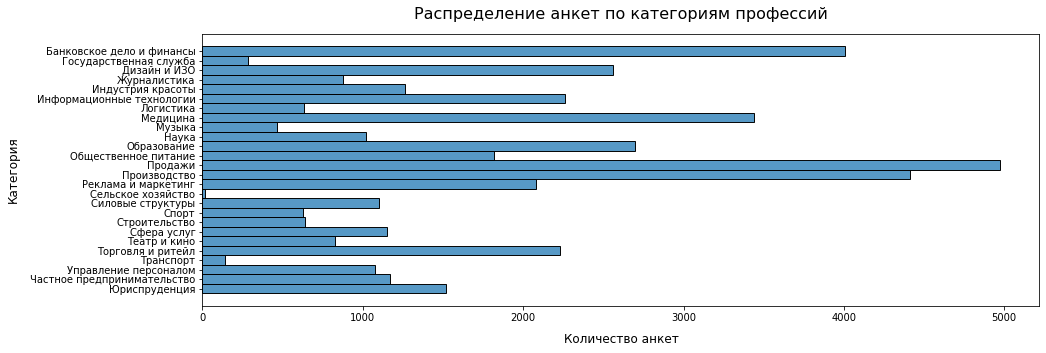

In [43]:
f, ax = plt.subplots(figsize=(15, 5))

plt.xlabel('Количество анкет', labelpad = 10, size = 12)
plt.ylabel('Категория', labelpad = 10, size = 12)
plt.title('Распределение анкет по категориям профессий', pad = 15, size = 16)

sns.histplot(y=df['category'], discrete=True)

plt.show()

### Выводы

Мы разделили данные на категории по профессии.

Чтобы не сильно углубляться в процесс настройки фильтров было принято решение обрабатывать только те леммы, количество вхождений который в датасет больше 50. При этоб было потеряно меньше 14% данных.

Очень мало данных в категории сельское хозяйство, но это ожидаемо. Попробуем построить модели оценки вероятности для полученных.

## Построение модели машинного обучения

Для обработки данных будем использовать только две модели машинного обучения:

 - LogisticRegression в качестве baseline
 - GradientBoostingClassifier в качестве основной модели (заказчик сообщил что использовал её до последнего времени)

Данные дисбалансированы, придётся проводить балансировку.

Будем пользоваться метриками F1, Accuracy, матрицей ошибок, Precision, Recall.

Попробуем сначал свести задачу к мультиклассовой классификации.

### Мультиклассовая классификация

Изменим настройки отображения для удобства просмотра.

In [44]:
set_config(display='diagram')

Удалим из набора данных лишние столбцы и разделим на тестовую и обучающую выборки.

In [45]:
df.drop(['q61', 'reviewed'], axis=1, inplace=True)

In [46]:
#df.drop(df[df['q62'] == 2].index, inplace=True)
#df.drop('q62', axis=1, inplace=True)
#df.reset_index(drop=True, inplace=True)

# создадим для каждой пары наборы признаков и целей
X = df.drop('category', axis=1)
y = df['category']
       
# разделим признаки и цели на train и valid наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=y
)

In [47]:
categorical = X.select_dtypes(include=['category', 'object']).columns.to_list()
numerical = X.select_dtypes(include='number').columns.to_list()

Проверим на случайной модели

In [48]:
model_dc = DummyClassifier(strategy='uniform', random_state=SEED)
model_dc.fit(X_train, y_train)
y_dc = model_dc.predict(X_test)

In [49]:
pd.DataFrame(classification_report(y_test, y_dc, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
Банковское дело и финансы,0.106,0.041,0.059,801.00
Государственная служба,0.003,0.018,0.005,57.00
Дизайн и ИЗО,0.051,0.035,0.042,512.00
Журналистика,0.031,0.057,0.040,175.00
Индустрия красоты,0.020,0.028,0.023,253.00
Информационные технологии,0.054,0.038,0.044,452.00
Логистика,0.006,0.016,0.009,126.00
Медицина,0.096,0.045,0.061,688.00
Музыка,0.006,0.022,0.010,93.00
Наука,0.029,0.049,0.037,204.00


А также на константной модели.

In [50]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=SEED)
model_dc_mf.fit(X_train, y_train)
y_dc_mf = model_dc_mf.predict(X_test)

In [51]:
pd.DataFrame(classification_report(y_test, y_dc_mf, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
Банковское дело и финансы,0.000,0.000,0.000,801.000
Государственная служба,0.000,0.000,0.000,57.000
Дизайн и ИЗО,0.000,0.000,0.000,512.000
Журналистика,0.000,0.000,0.000,175.000
Индустрия красоты,0.000,0.000,0.000,253.000
Информационные технологии,0.000,0.000,0.000,452.000
Логистика,0.000,0.000,0.000,126.000
Медицина,0.000,0.000,0.000,688.000
Музыка,0.000,0.000,0.000,93.000
Наука,0.000,0.000,0.000,204.000


#### LogisticRegression

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [52]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            drop='if_binary'
        ), categorical
    ),
    (
        StandardScaler(
        ), numerical
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [53]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        multi_class='multinomial',
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [54]:
param_grid = {
    'logisticregression__solver':['lbfgs'],
    'logisticregression__C':[1, .1],
    'logisticregression__max_iter':[100, 500]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [55]:
%time gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\User\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


CPU times: total: 1.19 s
Wall time: 1min 24s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype='uint8'),
                                                                         ['q1',
                                                                          'q2',
                                                                          'q3',
                                                                          'q4',
                                                                          'q5',
                                                                          'q6',
                                                                          'q7',
                                                                          'q8',
                                                                          'q9',
                                                                          'q10',
                                                                          'q11',
                                                                          'q12',
                                                                          'q13',
                                                                          'q14',
                                                                          'q15',
                                                                          'q16',
                                                                          'q17',
                                                                          'q18',
                                                                          'q19',
                                                                          'q20',
                                                                          'q21',
                                                                          'q22',
                                                                          'q23',
                                                                          'q24',
                                                                          'q25',
                                                                          'q26',
                                                                          'q27',
                                                                          'q28',
                                                                          'q29',
                                                                          'q30'...
                                                                          't21',
                                                                          't22',
                                                                          't23',
                                                                          't24',
                                                                          't25',
                                                                          't26',
                                                                          't27',
                                                                          't28',
                                                                          't29',
                                                                          't30', ...])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           multi_class='multinomial',
                                                           n_jobs=-1,
             

In [56]:
y_gs_lr = gs_lr.predict(X_test)
pd.DataFrame(classification_report(y_test, y_gs_lr, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
Банковское дело и финансы,0.196,0.077,0.111,801.000
Государственная служба,0.017,0.158,0.031,57.000
Дизайн и ИЗО,0.237,0.148,0.182,512.000
Журналистика,0.076,0.189,0.108,175.000
Индустрия красоты,0.063,0.051,0.057,253.000
Информационные технологии,0.183,0.124,0.148,452.000
Логистика,0.030,0.063,0.041,126.000
Медицина,0.208,0.032,0.055,688.000
Музыка,0.066,0.258,0.105,93.000
Наука,0.049,0.025,0.033,204.000


In [57]:
pd.DataFrame(gs_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.873713,0.477316,0.221199,0.019582,1,100,lbfgs,"{'logisticregression__C': 1, 'logisticregressi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,52.124143,3.706709,0.189402,0.065540,1,500,lbfgs,"{'logisticregression__C': 1, 'logisticregressi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,14.425547,0.352342,0.201205,0.018169,0.1,100,lbfgs,"{'logisticregression__C': 0.1, 'logisticregres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,25.036945,2.221562,0.115805,0.033216,0.1,500,lbfgs,"{'logisticregression__C': 0.1, 'logisticregres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


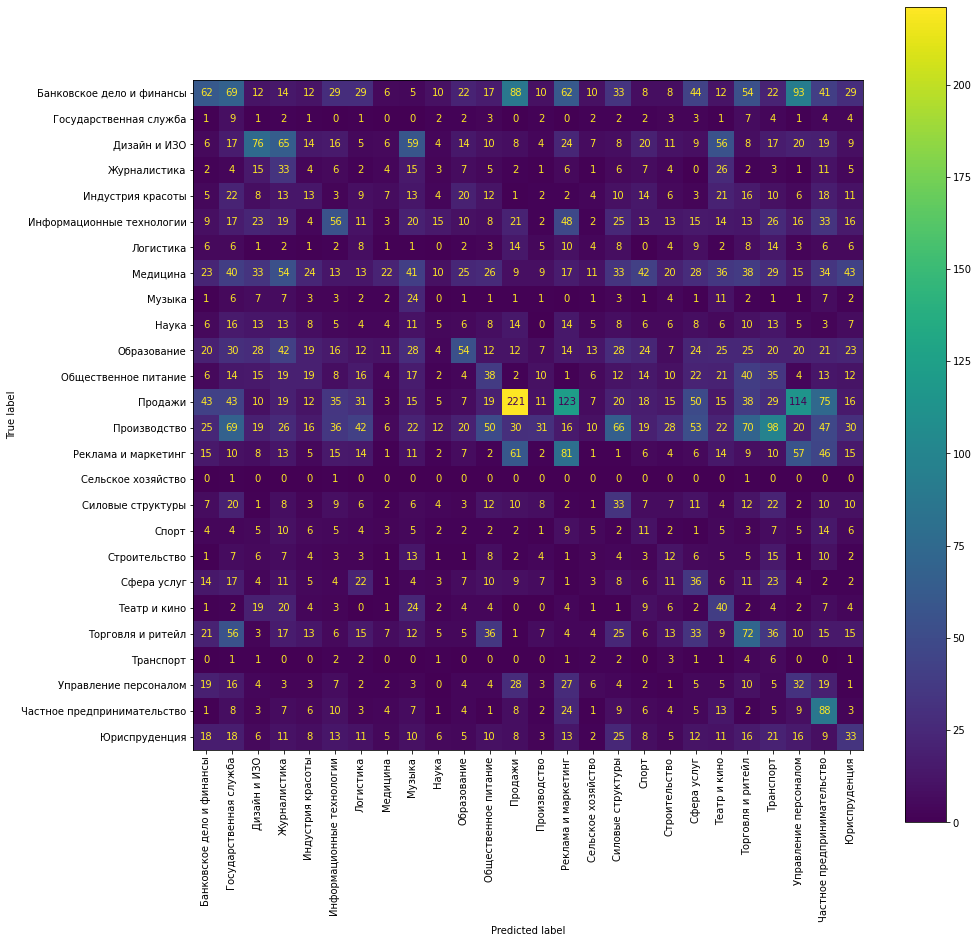

In [58]:
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(y_test, y_gs_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels=gs_lr.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()

#### Выводы

Матрица ошибок показывает лишь намёк на верное распределение. Вероятно, ответы на вопрос сами по себе не достаточно коррелируют с текущим распределением профессий. По нашим оценкам психотип человека должен больше оказывать влияние не на отрасль в которой трудится человек, а на компетенции в определённых направлениях работ. Например руководитель, инженер или рядовой рабочий могут быть почти в любой сфере. Но потребуют сходных компетенций от человека. При такой схеме лучшим распределением профессий будет двухуровневая схема на основе `Общероссийский классификатор занятий. ОК 010-2014 (МСКЗ-08)`, он же `International Standard Classification of Occupations (ISCO-08)`.

В нём первый уровень отвечает за общее направление/квалификацию работы (основные различия):
   - менеджеры
   - профессиональные
   - технические специалисты и младшие специалисты
   - канцелярские вспомогательные работники
   - работники сферы обслуживания и продажи
   - квалифицированные рабочие сельского, лесного и рыбного хозяйства
   - рабочие ремесленников и родственных профессий
   - машинисты, механизаторы, сборщики
   - элементарные профессии
   - вооруженные силы
   
В то время как подуровни детально расписывают сферу в которой трудятся люди с соответствующими компетенциями (оттенки):
   - менеджеры
    - руководители, высшие должностные лица и законодатели
    - административные и коммерческие менеджеры
    - менеджеры по производству и специализированным услугам
    - гостиничные, розничные и другие услуги менеджеры
    
Есть предположение что такое распределение позволит более рационально использовать зависимости в удовлетворённости работой от должности и сферы работы.

В данной работе попробуем ещё один подход к решению задачи классификации.

### Бинарная классификация для каждой профессии

Поскольку при текущем разделении корреляции достаточно слабые, попробуем разделить датасет на части по профессиям и уже для каждой из них по отдельности решить задачу бинарной классификации, где целевым признаком будет ответ на вопрос удовлетворяет ли текущая работа самореализоваться.

Для начала переведём ответы на целевой признак к 0-1, где 1 - "считаю что работа позволяет мне реализоваться".

In [59]:
df['q62'] = df['q62'].transform(lambda x: x if x == 1 else 0)

Выделим в отдельный датасет набор с данными по банковским работникам.

In [60]:
df_bank = df[df['category'] == 'Банковское дело и финансы'].copy()

Создадим наборы признаков и целей, а также разобьём на обучающую и тестовую выборки.

In [61]:
df_bank.drop('category', axis=1, inplace=True)

# создадим для каждой пары наборы признаков и целей
X = df_bank.drop('q62', axis=1)
y = df_bank['q62']
       
# разделим признаки и цели на train и valid наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=y
)

In [62]:
categorical = X.select_dtypes(include=['category', 'object']).columns.to_list()
numerical = X.select_dtypes(include='number').columns.to_list()

Проверим на случайной модели

In [63]:
model_dc = DummyClassifier(strategy='uniform', random_state=SEED)
model_dc.fit(X_train, y_train)
y_dc = model_dc.predict(X_test)

In [64]:
pd.DataFrame(classification_report(y_test, y_dc, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
0.0,0.484,0.548,0.514,367.000
1.0,0.570,0.507,0.537,434.000
accuracy,0.526,0.526,0.526,0.526
macro avg,0.527,0.527,0.525,801.000
weighted avg,0.531,0.526,0.526,801.000


А также на константной модели.

In [65]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=SEED)
model_dc_mf.fit(X_train, y_train)
y_dc_mf = model_dc_mf.predict(X_test)

In [66]:
pd.DataFrame(classification_report(y_test, y_dc_mf, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
0.0,0.000,0.000,0.000,367.000
1.0,0.542,1.000,0.703,434.000
accuracy,0.542,0.542,0.542,0.542
macro avg,0.271,0.500,0.351,801.000
weighted avg,0.294,0.542,0.381,801.000


#### LogisticRegression `Банковское дело и финансы`

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [67]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            drop='if_binary'
        ), categorical
    ),
    (
        StandardScaler(
        ), numerical
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [68]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [69]:
param_grid = {
    'logisticregression__penalty':['l2', 'none'],
    'logisticregression__solver':['newton-cg', 'lbfgs', 'sag'],
    'logisticregression__C':[1, .1, .01],
    'logisticregression__max_iter':[100, 500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [70]:
%time gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 4.22 s
Wall time: 21.8 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype='uint8'),
                                                                         ['q1',
                                                                          'q2',
                                                                          'q3',
                                                                          'q4',
                                                                          'q5',
                                                                          'q6',
                                                                          'q7',
                                                                          'q8',
                                                                          'q9',
                                                                          'q10',
                                                                          'q11',
                                                                          'q12',
                                                                          'q13',
                                                                          'q14',
                                                                          'q15',
                                                                          'q16',
                                                                          'q17',
                                                                          'q18',
                                                                          'q19',
                                                                          'q20',
                                                                          'q21',
                                                                          'q22',
                                                                          'q23',
                                                                          'q24',
                                                                          'q25',
                                                                          'q26',
                                                                          'q27',
                                                                          'q28',
                                                                          'q29',
                                                                          'q30'...
                                                                          't29',
                                                                          't30', ...])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           n_jobs=-1,
                                                           random_state=314159))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.1, 0.01],
                         'logisticregression__max_iter': [100, 500, 1000],
                         'logisticregression__penalty': ['l2', 'none'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'sag']},
             scoring='f1', verbose=1)

In [71]:
y_gs_lr = gs_lr.predict(X_test)
pd.DataFrame(classification_report(y_test, y_gs_lr, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
0.0,0.658,0.681,0.669,367.000
1.0,0.722,0.700,0.711,434.000
accuracy,0.692,0.692,0.692,0.692
macro avg,0.690,0.691,0.690,801.000
weighted avg,0.693,0.692,0.692,801.000


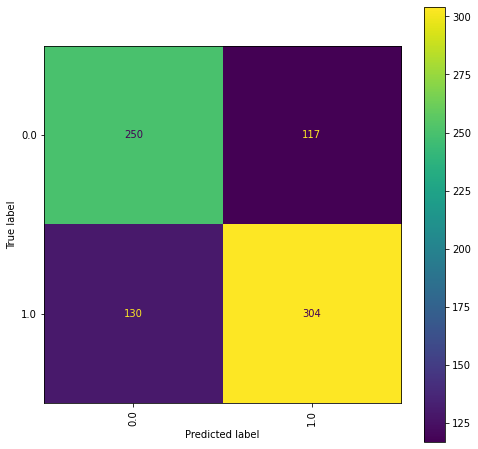

In [72]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, y_gs_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels=gs_lr.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()

Посмотрим на отдельные результаты.

In [73]:
gs_lr.predict_proba(X_test[0:10])

array([[0.42347373, 0.57652627],
       [0.87388404, 0.12611596],
       [0.39296425, 0.60703575],
       [0.64070056, 0.35929944],
       [0.69519265, 0.30480735],
       [0.17488494, 0.82511506],
       [0.60307654, 0.39692346],
       [0.44429071, 0.55570929],
       [0.4816329 , 0.5183671 ],
       [0.87461351, 0.12538649]])

In [74]:
df.iloc[y_test[0:10].index][['q62', 'category']].transpose()

,24001,10152,37289,8814,1985,36853,36048,36173,40865,19570
q62,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
category,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы,Банковское дело и финансы


#### LogisticRegression `Театр и кино`

Выделим в отдельный датасет набор с данными по категории Театр и кино.

In [75]:
df_theatre = df[df['category'] == 'Театр и кино'].copy()

Создадим наборы признаков и целей, а также разобьём на обучающую и тестовую выборки.

In [76]:
df_theatre.drop('category', axis=1, inplace=True)

# создадим для каждой пары наборы признаков и целей
X = df_theatre.drop('q62', axis=1)
y = df_theatre['q62']
       
# разделим признаки и цели на train и valid наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=y
)

In [77]:
categorical = X.select_dtypes(include=['category', 'object']).columns.to_list()
numerical = X.select_dtypes(include='number').columns.to_list()

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [78]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            drop='if_binary'
        ), categorical
    ),
    (
        StandardScaler(
        ), numerical
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [79]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [80]:
param_grid = {
    'logisticregression__penalty':['l2', 'none'],
    'logisticregression__solver':['newton-cg', 'lbfgs', 'sag'],
    'logisticregression__C':[1, .1, .01],
    'logisticregression__max_iter':[100, 500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [81]:
%time gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
CPU times: total: 2.3 s
Wall time: 12.9 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype='uint8'),
                                                                         ['q1',
                                                                          'q2',
                                                                          'q3',
                                                                          'q4',
                                                                          'q5',
                                                                          'q6',
                                                                          'q7',
                                                                          'q8',
                                                                          'q9',
                                                                          'q10',
                                                                          'q11',
                                                                          'q12',
                                                                          'q13',
                                                                          'q14',
                                                                          'q15',
                                                                          'q16',
                                                                          'q17',
                                                                          'q18',
                                                                          'q19',
                                                                          'q20',
                                                                          'q21',
                                                                          'q22',
                                                                          'q23',
                                                                          'q24',
                                                                          'q25',
                                                                          'q26',
                                                                          'q27',
                                                                          'q28',
                                                                          'q29',
                                                                          'q30'...
                                                                          't29',
                                                                          't30', ...])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           n_jobs=-1,
                                                           random_state=314159))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1, 0.1, 0.01],
                         'logisticregression__max_iter': [100, 500, 1000],
                         'logisticregression__penalty': ['l2', 'none'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'sag']},
             scoring='f1', verbose=1)

In [82]:
y_gs_lr = gs_lr.predict(X_test)
pd.DataFrame(classification_report(y_test, y_gs_lr, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
0.0,0.114,0.308,0.167,13.000
1.0,0.931,0.797,0.859,153.000
accuracy,0.759,0.759,0.759,0.759
macro avg,0.523,0.553,0.513,166.000
weighted avg,0.867,0.759,0.805,166.000


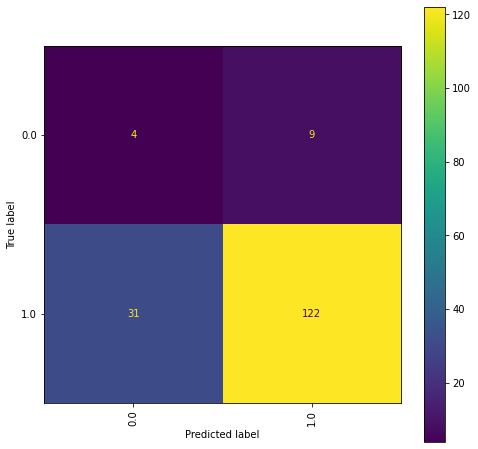

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, y_gs_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels=gs_lr.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()

Посмотрим на отдельные результаты.

In [84]:
gs_lr.predict_proba(X_test[0:10])

array([[1.00000000e+00, 3.66597461e-11],
       [4.12017309e-10, 1.00000000e+00],
       [1.13106110e-01, 8.86893890e-01],
       [2.26727089e-05, 9.99977327e-01],
       [9.70069846e-03, 9.90299302e-01],
       [7.70521635e-09, 9.99999992e-01],
       [2.34621616e-05, 9.99976538e-01],
       [2.01759314e-03, 9.97982407e-01],
       [9.99999889e-01, 1.10601259e-07],
       [1.25381807e-05, 9.99987462e-01]])

In [85]:
df.iloc[y_test[0:10].index][['q62', 'category']].transpose()

,13183,26375,27630,15458,10460,7101,1030,13264,18082,22085
q62,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
category,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино,Театр и кино


#### Выводы

На выборках с большим количеством ответов модель показывает неплохие результаты, но на категориях с маленьким количеством ответов или с большим дисбалансом качество сильно падает.

### Бинарная классификация для всех профессий

Также в качестве подхода попробуем придеставить профессии в качестве ещё одного признака, взяв за целевой ощущение собственной реализации работником.

Разделим на тестовую и обучающую выборки.

In [86]:
# создадим для каждой пары наборы признаков и целей
X = df.drop('q62', axis=1)
y = df['q62']
       
# разделим признаки и цели на train и valid наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=y
)

In [87]:
categorical = X.select_dtypes(include=['category', 'object']).columns.to_list()
numerical = X.select_dtypes(include='number').columns.to_list()

#### LogisticRegression

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [88]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            drop='if_binary'
        ), categorical
    ),
    (
        StandardScaler(
        ), numerical
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [89]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [90]:
param_grid = {
    'logisticregression__solver':['lbfgs'],
    'logisticregression__C':[1, .1],
    'logisticregression__max_iter':[100, 500]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [91]:
%time gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 1.05 s
Wall time: 20.7 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       dtype='uint8'),
                                                                         ['q1',
                                                                          'q2',
                                                                          'q3',
                                                                          'q4',
                                                                          'q5',
                                                                          'q6',
                                                                          'q7',
                                                                          'q8',
                                                                          'q9',
                                                                          'q10',
                                                                          'q11',
                                                                          'q12',
                                                                          'q13',
                                                                          'q14',
                                                                          'q15',
                                                                          'q16',
                                                                          'q17',
                                                                          'q18',
                                                                          'q19',
                                                                          'q20',
                                                                          'q21',
                                                                          'q22',
                                                                          'q23',
                                                                          'q24',
                                                                          'q25',
                                                                          'q26',
                                                                          'q27',
                                                                          'q28',
                                                                          'q29',
                                                                          'q30'...
                                                                          't17',
                                                                          't18',
                                                                          't19',
                                                                          't20',
                                                                          't21',
                                                                          't22',
                                                                          't23',
                                                                          't24',
                                                                          't25',
                                                                          't26',
                                                                          't27',
                                                                          't28',
                                                                          't29',
                                                                          't30', .

In [92]:
y_gs_lr = gs_lr.predict(X_test)
pd.DataFrame(classification_report(y_test, y_gs_lr, output_dict=True, zero_division=0)).round(decimals=3).transpose()

,precision,recall,f1-score,support
0.0,0.560,0.708,0.625,3055.0
1.0,0.814,0.696,0.750,5601.0
accuracy,0.700,0.700,0.700,0.7
macro avg,0.687,0.702,0.688,8656.0
weighted avg,0.724,0.700,0.706,8656.0


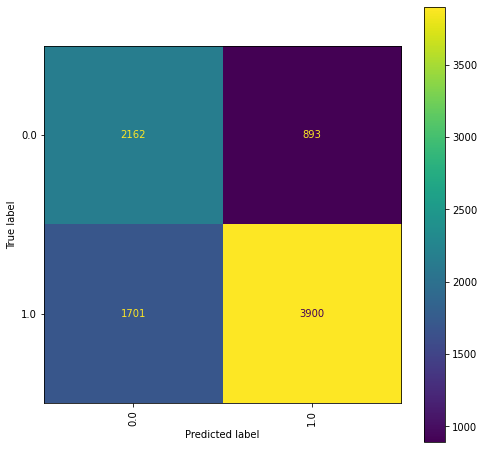

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, y_gs_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels=gs_lr.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()

Результат уже лучше. Попробуем для отдельной строки с ответами составить список профессий с вероятностями.

In [94]:
df.iloc[y_test.sample(n=1, random_state=SEED).index][['q62', 'category']]

,q62,category
454,1.0,Управление персоналом


In [95]:
gs_lr.predict_proba(X_test.sample(n=1, random_state=SEED))

array([[0.41333269, 0.58666731]])

Оригинальная категория `Управление персоналом`, степень удовлетворённости по модели составляет 58,7%

In [96]:
professions = {}

X = X_test.sample(n=1, random_state=SEED).copy()
for profession in initial_categories.keys():
    X['category'] = profession
    professions[profession] = (gs_lr.predict_proba(X)[0][1] * 100).round(decimals=2)

In [97]:
pd.DataFrame.from_dict(professions, orient='index').sort_values(0, ascending=False)

,0
Дизайн и ИЗО,86.39
Театр и кино,85.33
Журналистика,84.88
Музыка,82.54
Спорт,78.98
Частное предпринимательство,74.60
Индустрия красоты,65.11
Информационные технологии,63.74
Медицина,63.03
Реклама и маркетинг,62.26


#### Выводы

Данная концепция показала себя лучше всего, позволяя добиться `accuracy`=0.700 и `f1`=0.706

## Общие выводы

В ходе данной работы мы обработали датасет с ответами пользователей по тесту для определения психотипа по системе kpmi.

Очистили данные и подготовили к обработке.

Отдельным пунктом шла работа с ответом на вопрос о профессии, который пользователи давали в свободной форме, из-за чего данные были сильно загрязнены. Для исправления опечаток и ошибок нами был выбран простой, но, как показала практика, достаточно эффективный подход:
 - очистка данных с помощью регулярных выражений
 - фильтрация через список стоп-слов
 - поиск исправлений через минимальное редакционное расстояние с помощью алгоритма `SymSpell`
 - разделение на отдельные леммы
 - фильтрация лемм

При этом пришлось проделать отдельную работу по наполнению базового словаря для алгоритма.
 
После выделения чистых лемм мы создали систему фильтрации для отсеивания определённых профессий, ориентируясь на текущую систему с сайта kpmi.ru. Добавили соответствующий столбец с профессиями.

Для машинного обучения мы использовали три различных подхода:
 - мульти-классовая классификация (`accuracy`=0.127, `f1`=0.132)
 - бинарная классификация отдельно для каждой профессии (`accuracy`=0.692, `f1`=0.692)
 - бинарная классификация, профессия дополнительный признак (`accuracy`=0.700, `f1`=0.706)

Несмотря на скромные метрики у мульти-классовой классификации, все подходы показали результат лучше чем у случайной и константной моделей.

### Рекомендации заказчику

По моим скромным оценкам на психотип человека должны больше оказывать влияние не отрасль в которой трудится человек, а компетенции в определённых направлениях работ. Например, руководитель, инженер или рядовой рабочий могут быть почти в любой сфере. Но потребуют сходных компетенций от человека. При такой схеме лучшим распределением профессий будет двухуровневая схема на основе Общероссийский классификатор занятий. ОК 010-2014 (МСКЗ-08), он же International Standard Classification of Occupations (ISCO-08).

В нём первый уровень отвечает за общее направление/квалификацию работы (основные различия):

    менеджеры
    профессиональные
    технические специалисты и младшие специалисты
    канцелярские вспомогательные работники
    работники сферы обслуживания и продажи
    квалифицированные рабочие сельского, лесного и рыбного хозяйства
    рабочие ремесленников и родственных профессий
    машинисты, механизаторы, сборщики
    элементарные профессии
    вооруженные силы

В то время как подуровни детально расписывают сферу в которой трудятся люди с соответствующими компетенциями (оттенки):

    менеджеры
        руководители, высшие должностные лица и законодатели
        административные и коммерческие менеджеры
        менеджеры по производству и специализированным услугам
        гостиничные, розничные и другие услуги менеджеры

Есть предположение что такое распределение позволит более рационально использовать зависимости в удовлетворённости работой от должности и сферы работы.

Для пользователя же необходимо ограничить возможность свободного ввода профессии, т.к. это излишне усложняет интерпретацию результатов. Достаточно двух списков, где первый будет содержать 10 пунктов (с подсказками в виде типичных представителей группы, например:

*менеджеры (руководители, менеджеры, администраторы, законодатели)*

после чего будет появляться второй список со вторичной группой, содержащей от 3 до 6 пунктов на выбор.

### Список возможных доработок
 - тестирование с моделью **GradientBoostingClassifier**
 - тестирование каталогизатора на основе **МСКЗ-08/ISCO-08**